### Install Python Packages


In [52]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


### Import Libraries and Modules


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import html
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, precision_recall_curve, matthews_corrcoef
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from transformers import AutoTokenizer, TFBertModel, BertTokenizer, DistilBertTokenizer, BertForSequenceClassification, BertTokenizerFast, DistilBertForSequenceClassification, AdamW, DistilBertConfig, BertModel
import torch
import time
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [33]:
# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# Download necessary NLTK resources and 'omw-1.4' resource
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\Ashlan
[nltk_data]     Chang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ashlan
[nltk_data]     Chang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ashlan
[nltk_data]     Chang\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Load Dataset


In [35]:
df = pd.read_csv('FakeNewsNet.csv')

# Display basic statistics and info about the dataset

In [36]:
print("Dataset Information:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB
None

Descriptive Statistics:
          tweet_num          real
count  23196.000000  23196.000000
mean      88.956803      0.751897
std      488.694592      0.431921
min        0.000000      0.000000
25%       11.000000      1.000000
50%       37.000000      1.000000
75%       65.000000      1.000000
max    29060.000000      1.000000


# Check for any missing values

In [37]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64


# Remove columns that are not needed


In [38]:
# Keep only the 'title' and 'real' (label) columns
df = df[['title', 'real']]

# Print theupdated DataFrame
print(df.head())


                                               title  real
0  Kandi Burruss Explodes Over Rape Accusation on...     1
1  People's Choice Awards 2018: The best red carp...     1
2  Sophia Bush Sends Sweet Birthday Message to 'O...     1
3  Colombian singer Maluma sparks rumours of inap...     1
4  Gossip Girl 10 Years Later: How Upper East Sid...     1


# Data cleaning

In [39]:
# Text cleaning
def clean_text(text):
    # Remove HTML tags
    text = html.unescape(text)
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply text cleaning
df['clean_title'] = df['title'].apply(clean_text)

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['clean_title'] = df['clean_title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['clean_title'] = df['clean_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

print(df.head())


                                               title  real  \
0  Kandi Burruss Explodes Over Rape Accusation on...     1   
1  People's Choice Awards 2018: The best red carp...     1   
2  Sophia Bush Sends Sweet Birthday Message to 'O...     1   
3  Colombian singer Maluma sparks rumours of inap...     1   
4  Gossip Girl 10 Years Later: How Upper East Sid...     1   

                                         clean_title  
0  kandi burruss explodes rape accusation real ho...  
1           people choice award best red carpet look  
2  sophia bush sends sweet birthday message one t...  
3  colombian singer maluma spark rumour inappropr...  
4  gossip girl year later upper east siders shock...  


# Visualization amount of real vs fake news


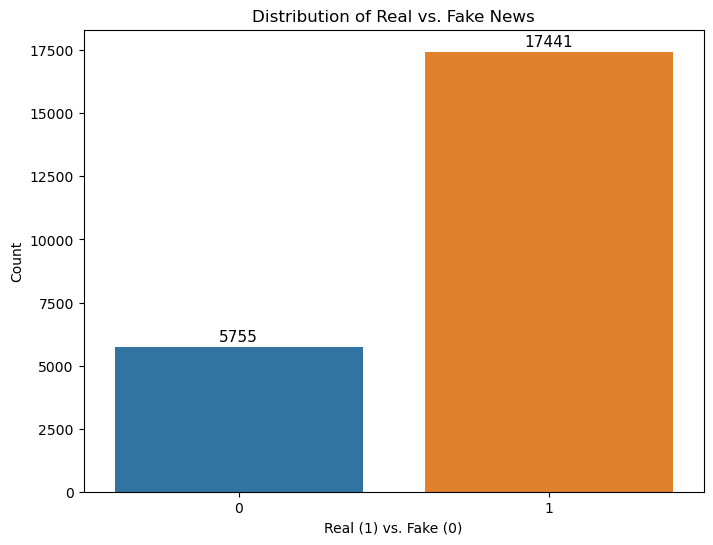

In [40]:
# Create countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='real')

# Title and labels
plt.title('Distribution of Real vs. Fake News')
plt.xlabel('Real (1) vs. Fake (0)')
plt.ylabel('Count')

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 7),
                textcoords='offset points')

# Show plot
plt.show()


# Initialize models

In [41]:
# Splitting Training and Testing sets
x_train, x_test, y_train, y_test = train_test_split(df["clean_title"], df["real"], test_size=0.25, random_state=42)

In [42]:
# Convert text to vectors
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [43]:
LR = LogisticRegression()
DT = DecisionTreeClassifier()
GBC = GradientBoostingClassifier(random_state=0)
RFC = RandomForestClassifier(random_state=0)

# Train the Model, Make Prediction, Print Classification Report

In [44]:
LR.fit(xv_train, y_train)
pred_lr = LR.predict(xv_test)
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.43      0.55      1390
           1       0.84      0.96      0.90      4409

    accuracy                           0.83      5799
   macro avg       0.80      0.70      0.73      5799
weighted avg       0.82      0.83      0.81      5799



In [45]:
DT.fit(xv_train, y_train)
pred_dt = DT.predict(xv_test)
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.54      0.52      0.53      1390
           1       0.85      0.86      0.86      4409

    accuracy                           0.78      5799
   macro avg       0.70      0.69      0.69      5799
weighted avg       0.78      0.78      0.78      5799



In [46]:
GBC.fit(xv_train, y_train)
pred_gbc = GBC.predict(xv_test)
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.78      0.27      0.40      1390
           1       0.81      0.98      0.88      4409

    accuracy                           0.81      5799
   macro avg       0.80      0.62      0.64      5799
weighted avg       0.80      0.81      0.77      5799



In [47]:
RFC.fit(xv_train, y_train)
pred_rfc = RFC.predict(xv_test)
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.70      0.49      0.58      1390
           1       0.85      0.93      0.89      4409

    accuracy                           0.83      5799
   macro avg       0.78      0.71      0.74      5799
weighted avg       0.82      0.83      0.82      5799



# Confusion Matrix

In [48]:
# For Logistic Regression
cm_lr = confusion_matrix(y_test, pred_lr)
print("Confusion Matrix:")
print(cm_lr)

# For Decision Tree
cm_dt = confusion_matrix(y_test, pred_dt)
print("Confusion Matrix:")
print(cm_dt)

# For Gradient Boosting
cm_gbc = confusion_matrix(y_test, pred_gbc)
print("Confusion Matrix:")
print(cm_gbc)

# For Random Forest
cm_rfc = confusion_matrix(y_test, pred_rfc)
print("Confusion Matrix:")
print(cm_rfc)

Confusion Matrix:
[[ 603  787]
 [ 185 4224]]
Confusion Matrix:
[[ 719  671]
 [ 611 3798]]
Confusion Matrix:
[[ 370 1020]
 [ 102 4307]]
Confusion Matrix:
[[ 684  706]
 [ 291 4118]]


# Visualisation: Plot Confusion Matrix

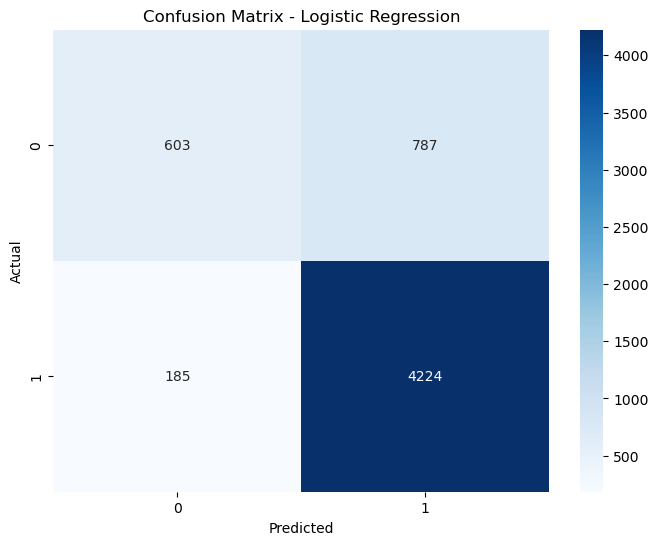

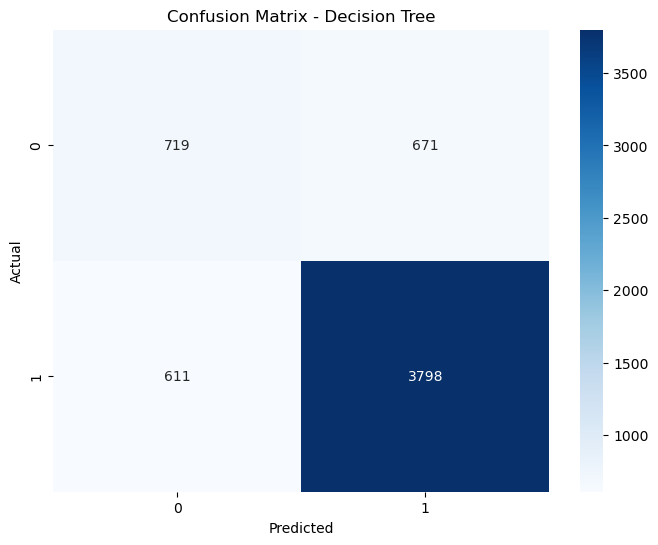

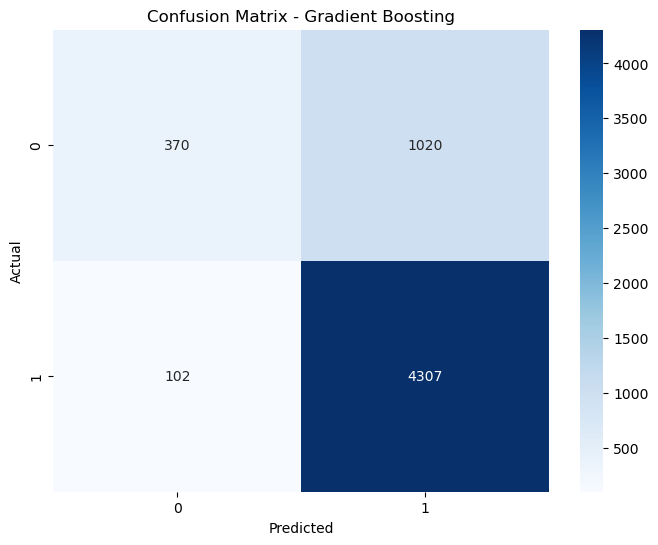

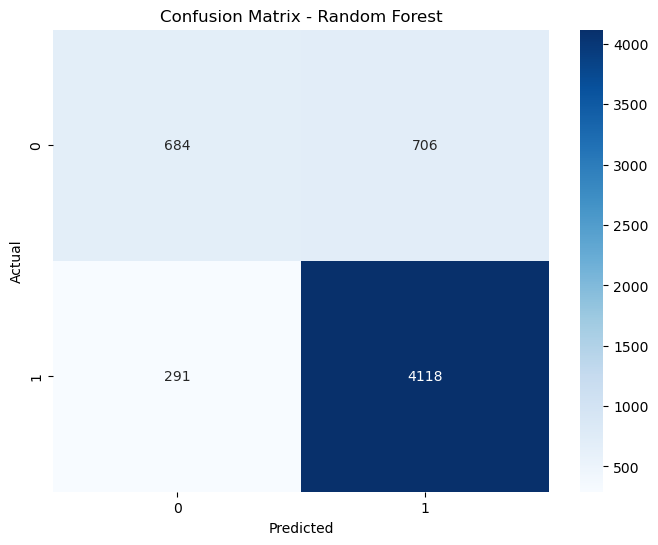

In [49]:
# Function to plot confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot for Logistic Regression
plot_cm(cm_lr, 'Confusion Matrix - Logistic Regression')

# Plot for Decision Tree
plot_cm(cm_dt, 'Confusion Matrix - Decision Tree')

# Plot for Gradient Boosting
plot_cm(cm_gbc, 'Confusion Matrix - Gradient Boosting')

# Plot for Random Forest
plot_cm(cm_rfc, 'Confusion Matrix - Random Forest')


# Testing Baseline Model

In [54]:
def manual_testing(title):
    # Create a new DataFrame with the provided title
    test_df = pd.DataFrame({'title': [title]})
    
    # Vectorize the title using the same vectorization method from the training phase
    new_test = vectorization.transform(test_df['title'])
    
    # Make predictions using the trained models
    pred_LR = LR.predict(new_test)
    pred_DT = DT.predict(new_test)
    pred_GBC = GBC.predict(new_test)
    pred_RFC = RFC.predict(new_test)
    
    # Display predictions
    print(f"\nLR Prediction: {'Real' if pred_LR[0] == 1 else 'Fake'}")
    print(f"DT Prediction: {'Real' if pred_DT[0] == 1 else 'Fake'}")
    print(f"GBC Prediction: {'Real' if pred_GBC[0] == 1 else 'Fake'}")
    print(f"RFC Prediction: {'Real' if pred_RFC[0] == 1 else 'Fake'}")

title_input = str(input("Enter a news title: "))
manual_testing(title_input)

Enter a news title: Donald trump is dead

LR Prediction: Fake
DT Prediction: Fake
GBC Prediction: Real
RFC Prediction: Fake


# Initialise BERT

In [22]:
# Define BERTClassifier architecture
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert 
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [23]:
# Load BERT model and tokenizer
bert_model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


In [24]:
# Split dataset into train and test sets using stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

train_texts, test_texts, train_labels, test_labels = train_test_split(df['clean_title'], df['real'], 
                                                                        random_state=2018, 
                                                                        test_size=0.2, 
                                                                        stratify=df['real'])

In [25]:
# Initialize lists to store evaluation results
test_preds_list = []
test_targets_list = []


In [26]:
for fold, (train_index, val_index) in enumerate(skf.split(train_texts, train_labels)):
    # Split train and validation data
    train_texts_fold = np.array(train_texts)[train_index]
    train_labels_fold = np.array(train_labels)[train_index]
    val_texts_fold = np.array(train_texts)[val_index]
    val_labels_fold = np.array(train_labels)[val_index]

In [27]:
# Tokenize and encode sequences
max_seq_length = 25 
tokens_train = tokenizer.batch_encode_plus(train_texts_fold.tolist(), max_length=max_seq_length, pad_to_max_length=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_texts_fold.tolist(), max_length=max_seq_length, pad_to_max_length=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_texts.tolist(), max_length=max_seq_length, pad_to_max_length=True, truncation=True)

In [28]:
# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(tokens_train['input_ids']), 
                              torch.tensor(tokens_train['attention_mask']), 
                              torch.tensor(train_labels_fold.tolist()))

val_dataset = TensorDataset(torch.tensor(tokens_val['input_ids']), 
                            torch.tensor(tokens_val['attention_mask']), 
                            torch.tensor(val_labels_fold.tolist()))

test_dataset = TensorDataset(torch.tensor(tokens_test['input_ids']), 
                             torch.tensor(tokens_test['attention_mask']), 
                             torch.tensor(test_labels.tolist()))


In [29]:
# Define dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Initialize BERTClassifier model
model = BERTClassifier(bert_model).to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss(weight=torch.tensor([1.0, 10.0]).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)  

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)


In [30]:
# Training loop
num_epochs = 3 
best_val_loss = float('inf')
# Initialize variable to store the best model for each fold
best_model_fold = None  
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f'Fold [{fold+1}/3], Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Fold [3/3], Epoch [1/3], Loss: 0.1379
Fold [3/3], Epoch [2/3], Loss: 0.1021
Fold [3/3], Epoch [3/3], Loss: 0.0781


In [31]:
# Validation
model.eval()
val_loss = 0.0
with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

val_loss /= len(val_dataloader)
print(f'Fold [{fold+1}/3], Validation Loss: {val_loss:.4f}')


Fold [3/3], Validation Loss: 0.1409


In [32]:
# Update learning rate scheduler
scheduler.step(val_loss)

# Save the best model
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model_fold = model.state_dict()
# Save the best model for this fold after training completes
if best_model_fold is not None:
    torch.save(best_model_fold, f'bert_classifier_fold{fold}_best.pth')


In [33]:
# Evaluation on test set for this fold
model.load_state_dict(best_model_fold) 
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())
    
test_preds_list.append(test_preds)
test_targets_list.append(test_targets)

# Calculate overall evaluation metrics across all folds
test_preds_all = np.concatenate(test_preds_list)
test_targets_all = np.concatenate(test_targets_list)
print(classification_report(test_targets_all, test_preds_all))
 

              precision    recall  f1-score   support

           0       0.78      0.45      0.57      1151
           1       0.84      0.96      0.90      3489

    accuracy                           0.83      4640
   macro avg       0.81      0.71      0.73      4640
weighted avg       0.83      0.83      0.82      4640



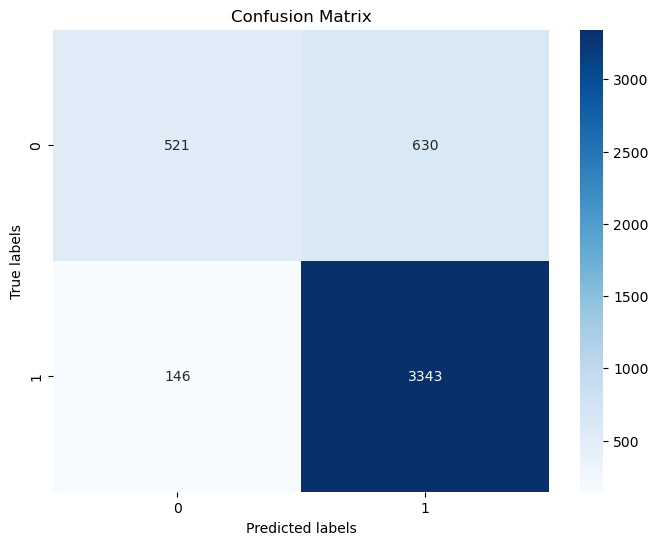

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_mat = confusion_matrix(test_targets_all, test_preds_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


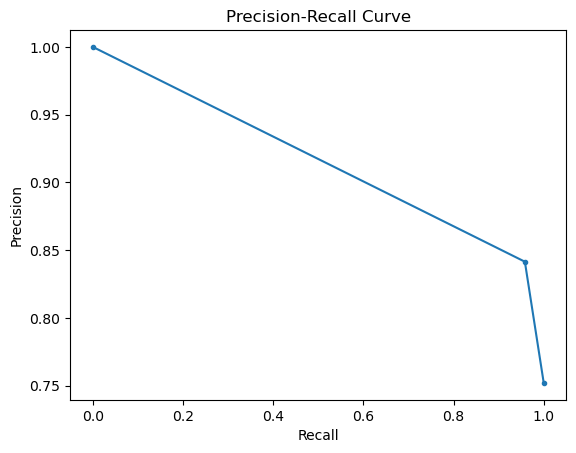

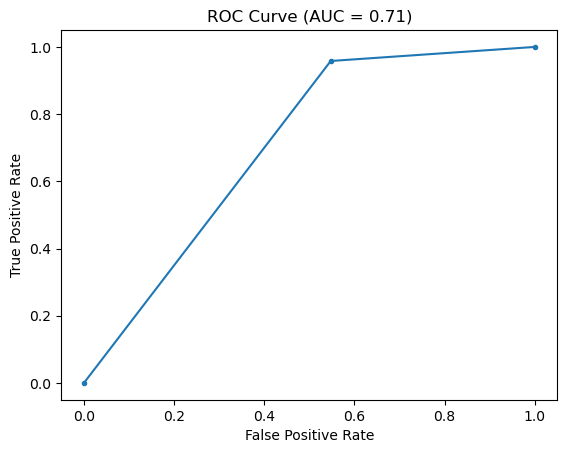

In [42]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# For binary classification, compute precision-recall curve
precision, recall, _ = precision_recall_curve(test_targets_all, test_preds_all)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# compute ROC curve
fpr, tpr, _ = roc_curve(test_targets_all, test_preds_all)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.show()


In [46]:
# Save the model with the updated pretrained weights
torch.save(model.state_dict(), 'final_weights2.pt')


In [49]:
# Load the model with the new pretrained weights
new_model = BERTClassifier(bert_model).to(device)
new_model.load_state_dict(torch.load('final_weights2.pt'))

# Evaluate the new model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            preds = model(input_ids, attention_mask)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Evaluate on validation set
val_preds, val_labels = evaluate_model(new_model, val_dataloader)

# Print classification report
print(classification_report(val_labels, val_preds))


              precision    recall  f1-score   support

           0       0.79      0.47      0.59      1534
           1       0.85      0.96      0.90      4651

    accuracy                           0.84      6185
   macro avg       0.82      0.71      0.74      6185
weighted avg       0.83      0.84      0.82      6185



In [50]:
import torch
from transformers import BertTokenizerFast

# Function to preprocess and tokenize the input title
def preprocess_title(title):
    # Load the tokenizer
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    
    # Tokenize the title
    tokenized_title = tokenizer(title, padding=True, truncation=True, return_tensors='pt')
    
    return tokenized_title

# Function to predict the true or false for the input title
def predict_title_label(model, tokenized_title):
    # Make prediction
    with torch.no_grad():
        output = model(tokenized_title['input_ids'], tokenized_title['attention_mask'])
        predicted_label = torch.argmax(output, dim=1).item()
    
    # Map predicted label to true or false
    label_mapping = {0: 'false', 1: 'true'}
    predicted_label_text = label_mapping[predicted_label]
    
    return predicted_label_text

# Function to predict label for input title
def predict_title(model, title):
    # Preprocess and tokenize the input title
    tokenized_title = preprocess_title(title)
    
    # Predict label for tokenized title
    predicted_label = predict_title_label(model, tokenized_title)
    
    return predicted_label

# Example usage
title = "‘WAGS Miami’ Stars Ashley Nicole Roberts and Philip Wheeler Are Married"
predicted_label = predict_title(new_model, title)
print(f"The predicted label for the title '{title}' is: {predicted_label}")


The predicted label for the title '‘WAGS Miami’ Stars Ashley Nicole Roberts and Philip Wheeler Are Married' is: true
